In [ ]:
from pyquaternion import Quaternion
import numpy as np
from numpy import linalg as LA

# TO CHANGE
from surgeon_recording.data_analysis.tool_transformation import *
from surgeon_recording.reader_wo_align_rel_time import Reader #car sinon tronque encore les valeurs quand lit les fichiers segmentes, pas utile ? a revoir !

from glob import glob
from os.path import join
import os
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd
import csv
import matplotlib.pyplot as plt
import natsort
import matplotlib
import math

# Compute the transformation matrix from marker to tip and marker to tool (put in a function so commented)

In [7]:
# hardcoded tool and tooltip rotation and position in form [qw,qx,qy,qz,tx,ty,tz,1]
#  Quaternion((w, x, y, z)) function: Creates a unit quaternion 1 + 0i + 0j + 0k
# approximation for the 1st set of recorded data (not exact as fell several times + position measured afterwards, the marker was not placed exactly at same location)

#done in 2 times: once with 3 points to show the top and once with 3 points to show the tip = two different matrix for the main marker used during the experiment
#tools = {
#    "tweezers": {
#        "marker_top": [0.294683893, -0.381338443, 0.804004129, -0,348218245, 0.02071305, 0.315910506, 0.109691984, 1],     # the one from the fixed marker for top measurement
#        "marker_tip": [-0.934570634, -0.199016144, -0.27846308, -0.09708261, -0.084385462, 0.322035324, 0.247498733, 1],     # the one from the fixed marker for tip measurement
#        "top":  [-0.957423623, 0.232203992, 0.045994597, -0.164969258, -0.957423623, 0.064656852, 0.30305547, 0.118855763,1],    # marker to rpz top
#        "tip":  [-0.982271943, 0.074956687, 0.087323391, -0.147737227, 0.009193922, 0.29774011, 0.185825182, 1]      # marker to rpz tip
        
#    },
#    "holder":  {
 #       "marker_top": [-0.464328416, -0.824174638, 0.259212521, 0.194345126, -0.028731799, 0.37167886, 0.187163421, 1],
#        "marker_tip": [-0.607490434, -0.786474846, 0.065937201, 0.066721948, -0.09777691, 0.273007487, 0.129043679, 1],
#        "top": [-0.999966857, -0.005855143, 0.001344358, -0.004240937, 0.038997519, 0.391597069, 0.185368827, 1],
#        "tip":  [-0.998836327, 0.047065242, 0.006078749, -0.008203204, -0.003049673, 0.288822714, 0.204019114, 1]

#    },        
#    "scissors": {
#        "marker_top": [-0.042840319, -0.680377306, -0.566847792, 0.46252974, -0.081934339, 0.350532647, 0.195744726, 1],
#        "marker_tip": [0.006243079, -0.843461761, -0.292836166, 0.450291385, 0.091436198, 0.357834012, 0.119615055, 1],
#        "top": [-0.998896472, -0.011071288, 0.035124272, -0.028830308, -0.010444363, 0.372744524, 0.189865359, 1],
#        "tip": [-0.174518025, -0.309318304, 0.422878875, 0.833678217, 0.052825127, 0.265624369, 0.148519055, 1]
#    }
#}

In [ ]:
#for tool in tools:
#    print(tool)
#    marker_top_quaternion = Quaternion(tools[tool]["marker_top"][:4])  #Return homogeneous rotation matrix from quaternion. = on calcule la matrice de rotation qui correspond aux quaternions du tool (chiffres en haut) #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
#    T_marker_top_fixed = marker_top_quaternion.transformation_matrix         # deja en 4*4 matrix
    
#    marker_top_translation_vector = np.array((tools[tool]["marker_top"][-4:])) #Return matrix to translate by direction vector = on calcule la matrice de translation qui correspond aux positions du tool (chiffres en haut)
#    T_marker_top_fixed[:,-1] = marker_top_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (marker de l'outils)
    
#    marker_tip_quaternion = Quaternion(tools[tool]["marker_tip"][:4])  #Return homogeneous rotation matrix from quaternion. = on calcule la matrice de rotation qui correspond aux quaternions du tool (chiffres en haut) #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
#    T_marker_tip_fixed = marker_tip_quaternion.transformation_matrix         # deja en 4*4 matrix
#    
#    marker_tip_translation_vector = np.array((tools[tool]["marker_tip"][-4:])) #Return matrix to translate by direction vector = on calcule la matrice de translation qui correspond aux positions du tool (chiffres en haut)
#    T_marker_tip_fixed[:,-1] = marker_tip_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (marker de l'outils)
        
#    top_quaternion = Quaternion(tools[tool]["top"][:4])  #Return homogeneous rotation matrix from quaternion. = on calcule la matrice de rotation qui correspond aux quaternions du tool (chiffres en haut) #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
#    T_top = top_quaternion.transformation_matrix         # deja en 4*4 matrix
    
#    top_translation_vector = np.array((tools[tool]["top"][-4:])) #Return matrix to translate by direction vector = on calcule la matrice de translation qui correspond aux positions du tool (chiffres en haut)
#    T_top[:,-1] = top_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (marker de l'outils)
    
#    tip_quaternion = Quaternion(tools[tool]["tip"][:4]) #matrice de rotation des quaternions du tip #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
#    T_tip = tip_quaternion.transformation_matrix
  
#    tip_translation_vector = np.array((tools[tool]["tip"][-4:])) #-4 car 4 dernieres valeurs
#    T_tip[:,-1] = tip_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (tip de l'outils)
    
#    T_marker_top_fixed_inv = LA.inv(T_marker_top_fixed)  
#    T_marker_tip_fixed_inv = LA.inv(T_marker_tip_fixed)  
#    #T_marker_inv = np.identity(4)
#    #T_marker_inv[:3, :3] = LA.inv(T_tool[:3, :3])
#    #T_marker_inv[:3, -1] = -T_tool_inv[:3, :3].dot(T_tool[:3, -1]) #msimplement une autre maniere de la calculer l'inverse !!!!!!!!!!!!!!
   
    
## ORIGIN TO TOOL, BASED ON MARKER POSITION
   
#    T_marker_top = T_marker_top_fixed_inv.dot(T_top) #Matrice mTtop = marker to top
#    q_marker_tool = Quaternion(matrix = T_marker_top)

    
## ORIGIN TO TIP, BASED ON MARKER POSITION
     
#    T_marker_tip = T_marker_tip_fixed_inv.dot(T_tip) #Matrice mTtip = marker to tip
#    q_marker_tip = Quaternion(matrix = T_marker_tip)
    

# get Optitrack data

In [9]:
# pour avoir x,y,z tip on multplie la matrice mTt (cste) par oTm qui varie a chaque instant
#besoin du vecteur de translation de la matrice oTt (origin to tip) pour avoir la positio du tip = multiplication de oTm et mTt, oTm connue = Ttool a chaque instant

In [10]:
# EN REALITE TOOL EST MARQUEUR DONC BESOIN DE REFAIRE PAREIL POUR LE VRAI HAUT DU TOOL SI ON VEUT PLUS PRECIS
# DESIGNER MARQUEUR POUR QUE CE SOIT PLUS SIMPLE

In [2]:
reader = Reader()

In [3]:
data_folder = join('..', 'data','SEGMENTATION_suturing_cutting')
#subject_nb = ['12']
subject_nb = ['12', '14', '15', '20','22'] # 15 run 1 incomplete ? (5 cutting and 5 suturing)
blacklist = ['15']
print("WARNING: segmentation for 14,20 and 22 from alreadz segmented parts = relative time does not alwazs correspond to the initial file relative time")

experiment = 'chicken'

sensors_file = ['camera.csv', 'optitrack.csv','emg.csv','tps.csv']

sensors = ['camera', 'optitrack','emg','tps']

action = ['suturing', 'cutting']
#action = 'cutting'


specialty_keys = ["neuro", "plastic"]
expertise_keys = ["novice", "expert"]

tools = ['tweezers','holder','scissors']

In [4]:
# declaration variable
run_dir = {}
opti_data = {}

for a in action:
    run_dir[a] = {}
    opti_data[a] = {}
    
    for d in subject_nb:
        run_dir[a][d] = {}
        opti_data[a][d] = {}
        
        for l in tools:
                for f in ['x','y','z','qx','qy','qz','qw']:
                    key = l + '_' + f 
                    opti_data[a][d][key] = []
                    
  

In [5]:
# directory of files
#ATTENTION: OK SI UN SEUL RUN DANS LE DOCUMENT SEGMENTATION POUR L'INSTANT

for a in action:
    for d in subject_nb:
        tmp = [x[0] for x in os.walk(join(data_folder, d, experiment,'segmentation',a))][2:]
        run_dir[a][d] = natsort.natsorted(tmp,reverse=False)
        print(a)
        print(d)
       # print(run_dir[a][d])
       # print("-----------------------------")
#print(run_dir)

suturing
12
suturing
14
suturing
15
suturing
20
suturing
22
cutting
12
cutting
14
cutting
15
cutting
20
cutting
22


In [6]:
# data of different segments for one action and one subject put together
for a in action:
    for d in subject_nb:  
        for rd in run_dir[a][d]:
            reader.play(rd) 
            for l in tools:
                for f in ['x','y','z','qx','qy','qz','qw']:
                    key = l + '_' + f 
                    opti_data[a][d][key].append(reader.data['optitrack'][key].to_numpy())  #add opti data for one action, one subject, one key in one structure
            

## transform data 

In [7]:
# need to put them in the format to compute oTmarker
translation_vector = {}
quaternion_vector = {}
position_vector_tip = {}
position_vector_top = {}
vector_top_to_tip = {}
pos_x = {}
pos_y = {}
pos_z = {}

for a in action:
    translation_vector[a] = {}
    quaternion_vector[a] = {}
    position_vector_tip[a] = {}
    position_vector_top[a] = {}
    vector_top_to_tip[a] = {}
    pos_x[a]= {}
    pos_y[a]= {}
    pos_z[a]= {}
    
    for d in subject_nb:  
        translation_vector[a][d] = {}
        quaternion_vector[a][d] = {}
        position_vector_tip[a][d] = {}
        position_vector_top[a][d] = {} 
        vector_top_to_tip[a][d] = {}
        pos_x[a][d]= {}
        pos_y[a][d]= {}
        pos_z[a][d]= {}
        
        id_s = len(run_dir[a][d])
        for s in range(id_s): #s prend la valeur des segments
            translation_vector[a][d][s] = {}
            quaternion_vector[a][d][s] = {}
            position_vector_top[a][d][s] = {}
            position_vector_tip[a][d][s] = {}
            vector_top_to_tip[a][d][s] = {}
            pos_x[a][d][s] = {}
            pos_y[a][d][s] = {}
            pos_z[a][d][s] = {}
            
            for tool in tools:
                T_marker_top=[]
                T_marker_tip = []
                [T_marker_top, T_marker_tip] = get_transformation_matrix(tool)
                
                position_vector_tip[a][d][s][tool] = []
                position_vector_top[a][d][s][tool] = []
                translation_vector[a][d][s][tool] = []
                quaternion_vector[a][d][s][tool] = []
                vector_top_to_tip[a][d][s][tool] = []
                pos_x[a][d][s][tool] = []
                pos_y[a][d][s][tool] = []
                pos_z[a][d][s][tool] = []
                
                for i in range(len(opti_data[a][d][tool + '_' + 'x'][s])):
                    current_trans_vect = np.array([opti_data[a][d][tool + '_' + 'x'][s][i], opti_data[a][d][tool + '_' + 'y'][s][i], opti_data[a][d][tool + '_' + 'z'][s][i],1])
                    translation_vector[a][d][s][tool].append(current_trans_vect)
                    current_quaternion = np.array([opti_data[a][d][tool + '_' + 'qw'][s][i], opti_data[a][d][tool + '_' + 'qx'][s][i], opti_data[a][d][tool + '_' + 'qy'][s][i], opti_data[a][d][tool + '_' + 'qz'][s][i]])
                    #ajoute a la suite pour une action, 1 sujet, un outils et un sgment le vecteur ieme vecteur x,y,z 
                    q = Quaternion(current_quaternion)
                    quaternion_vector[a][d][s][tool].append(current_quaternion)                       
                   
                    T_marker = q.transformation_matrix        
                    T_marker[:,-1] = current_trans_vect
                    
                    tmp_pos_tip = T_marker.dot(T_marker_tip)[0:3,-1]
                    tmp_pos_top = T_marker.dot(T_marker_top)[0:3,-1]
                    
                    position_vector_tip[a][d][s][tool].append(tmp_pos_tip) #prend le vecteur de translation de la matrice obtenue qui correspond a la position par rapport au referentiel
                    position_vector_top[a][d][s][tool].append(tmp_pos_top)
                    
                    tmp_top_to_tip = np.subtract(tmp_pos_tip, tmp_pos_top)
                    
                    vector_top_to_tip[a][d][s][tool].append(tmp_top_to_tip) #format x,y,y
                
                pos_x[a][d][s][tool] = [item[0] for item in vector_top_to_tip[a][d][s][tool]]  #que les x
                pos_y[a][d][s][tool] = [item[1] for item in vector_top_to_tip[a][d][s][tool]]  
                pos_z[a][d][s][tool] = [item[2] for item in vector_top_to_tip[a][d][s][tool]]

## Compute motion dynamics

In [60]:
# calcul vitesse
pos = {}
speed = {}
acc = {}
jerk = {}
x_speed = {}
amp_speed = {}

frequency_theo = 65
for a in action:
    pos[a] = {}
    speed[a] = {}
    acc[a] = {}
    jerk[a] = {}
    x_speed[a] = {}
    amp_speed[a] = {}
    
    for d in subject_nb:  
        pos[a][d] = {}
        speed[a][d] = {}
        acc[a][d] = {}
        jerk[a][d] = {}
        x_speed[a][d] = {}
        amp_speed[a][d] = {}
        
        id_s = len(run_dir[a][d])
        for s in range(id_s): #s prend la valeur des segments
            pos[a][d][s] = {}
            speed[a][d][s] = {}
            acc[a][d][s] = {}
            jerk[a][d][s] = {}
            x_speed[a][d][s] = {}
            amp_speed[a][d][s] = {}
            
            for tool in tools:
                amp_speed[a][d][s][tool] = []
###################### should use potition tip directly and use the actual frequency obtained to have accurate dt between points for the derivative#############################
               
                # speed[a][d][s][tool] = np.gradient(vector_top_to_tip[a][d][s][tool], frequency_theo, axis = 0) 
               # acc[a][d][s][tool] = np.gradient(speed[a][d][s][tool], frequency_theo, axis = 0)               #format (x,y,z)
               # jerk[a][d][s][tool] = np.gradient(acc[a][d][s][tool], frequency_theo, axis = 0)
                
               # x_speed[a][d][s][tool] = np.gradient(pos_x[a][d][s][tool], frequency_theo)       #x point
               # y_speed[a][d][s][tool] = np.gradient(pos_y[a][d][s][tool], frequency_theo)       #y point
               # z_speed[a][d][s][tool] = np.gradient(pos_z[a][d][s][tool], frequency_theo)       #z point
                
                for i in range(len(speed[a][d][s][tool])):
                    amp_speed[a][d][s][tool].append(LA.norm(speed[a][d][s][tool][i]))
        



## compute angles

In [11]:
# calcul angles 

#vecteurs directeurs
vect_i = np.array([1,0,0])
vect_j = np.array([0,1,0])
vect_k = np.array([0,0,1])

angle_x  = {}
angle_y  = {}
angle_z  = {}
angle_z_from_tip  = {}

for a in action:
    angle_x[a]={}
    angle_y[a]={}
    angle_z[a]={}
    angle_z_from_tip[a]={}
    for d in subject_nb: 
        angle_x[a][d]={}
        angle_y[a][d]={}
        angle_z[a][d]={}
        angle_z_from_tip[a][d]={}
        id_s = len(run_dir[a][d])        
        for s in range(id_s): #s prend la valeur des segments
            angle_x[a][d][s]={}
            angle_y[a][d][s]={}
            angle_z[a][d][s]={}
            angle_z_from_tip[a][d][s] = {}
            for tool in tools:
                angle_x[a][d][s][tool] = []
                angle_y[a][d][s][tool] = []
                angle_z[a][d][s][tool] = []
                angle_z_from_tip[a][d][s][tool] = []
                for i in range(len(vector_top_to_tip[a][d][s][tool])):
                    current_vector = vector_top_to_tip[a][d][s][tool][i]
                    norm_current_vector = LA.norm(current_vector)
                    alpha = np.arccos((current_vector.dot(vect_i))/norm_current_vector)
                    beta = np.arccos((current_vector.dot(vect_j))/norm_current_vector)
                    gamma = np.arccos((current_vector.dot(vect_k))/norm_current_vector)
                    
                    angle_x[a][d][s][tool].append(math.degrees(alpha))
                    angle_y[a][d][s][tool].append(math.degrees(beta))
                    angle_z[a][d][s][tool].append(math.degrees(gamma))
                    angle_z_from_tip[a][d][s][tool].append(math.degrees(math.pi-gamma))
                    

## Graphs

<Figure size 432x288 with 0 Axes>

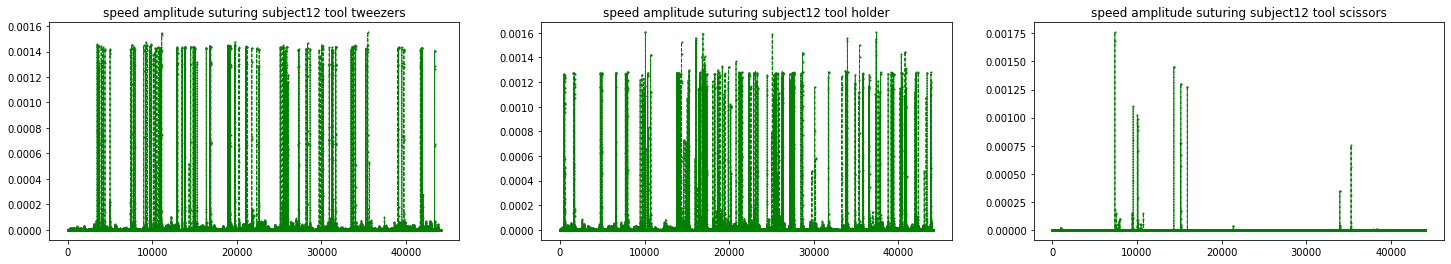

<Figure size 432x288 with 0 Axes>

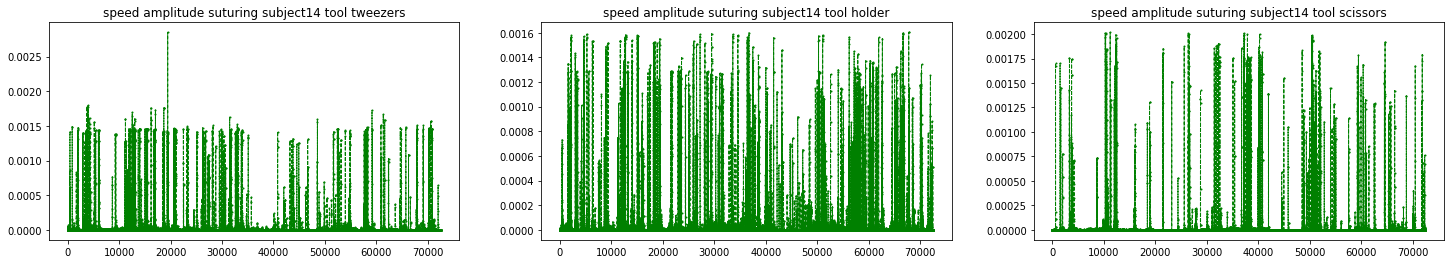

<Figure size 432x288 with 0 Axes>

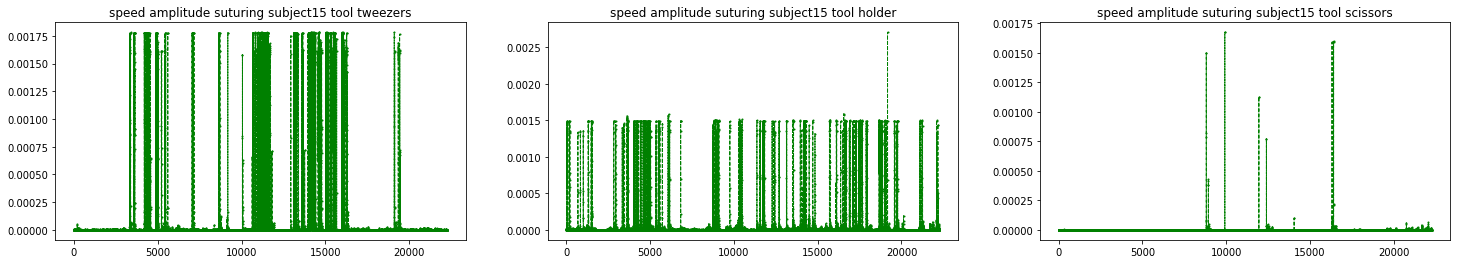

<Figure size 432x288 with 0 Axes>

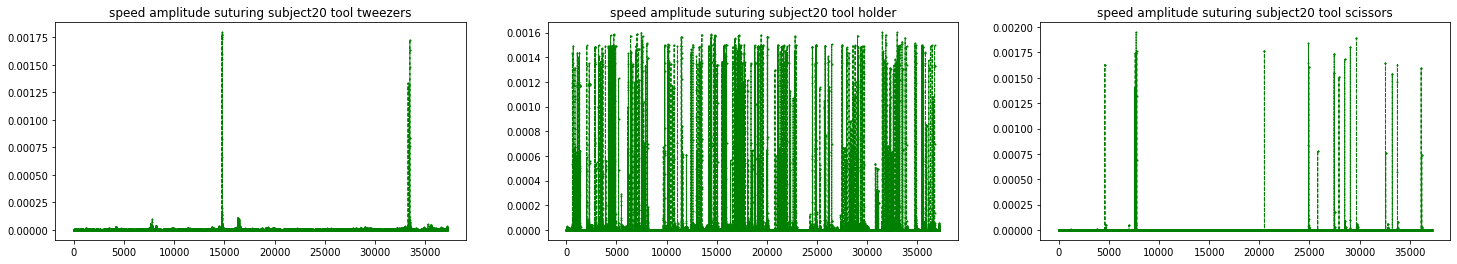

<Figure size 432x288 with 0 Axes>

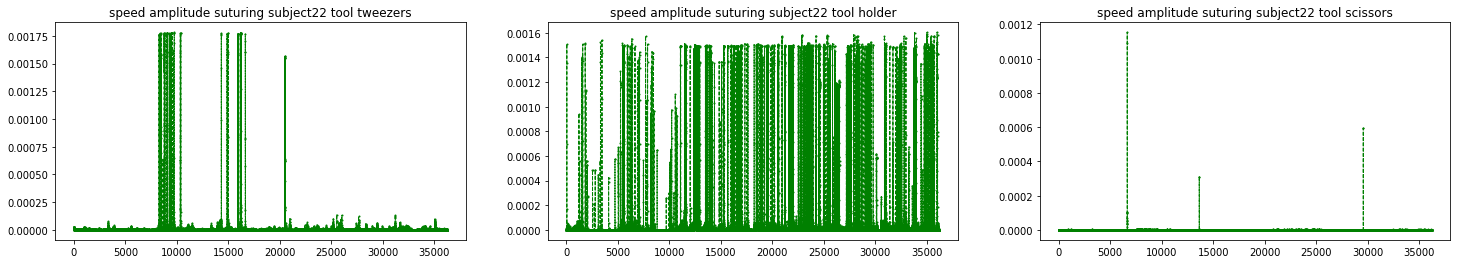

<Figure size 432x288 with 0 Axes>

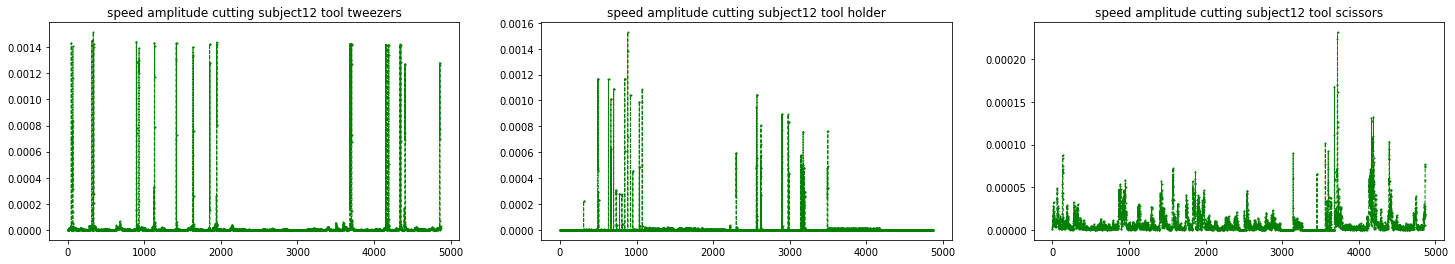

<Figure size 432x288 with 0 Axes>

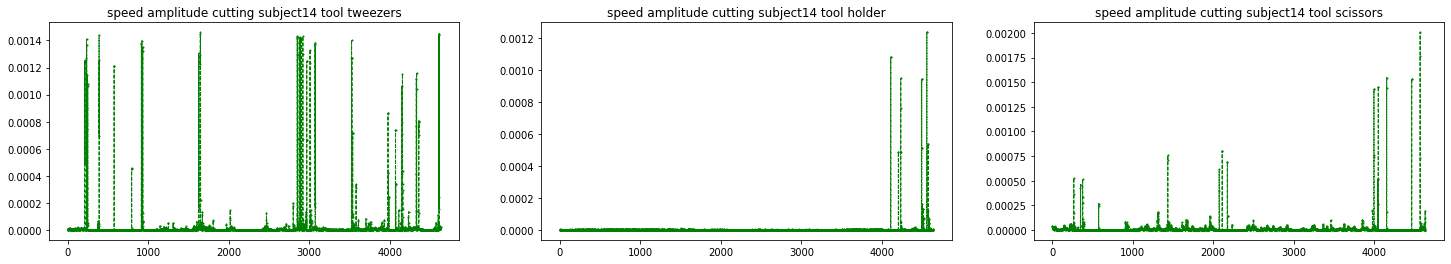

<Figure size 432x288 with 0 Axes>

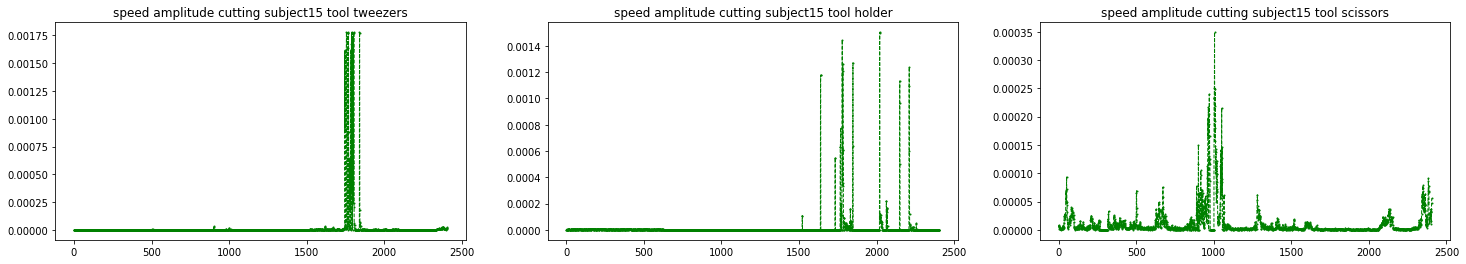

<Figure size 432x288 with 0 Axes>

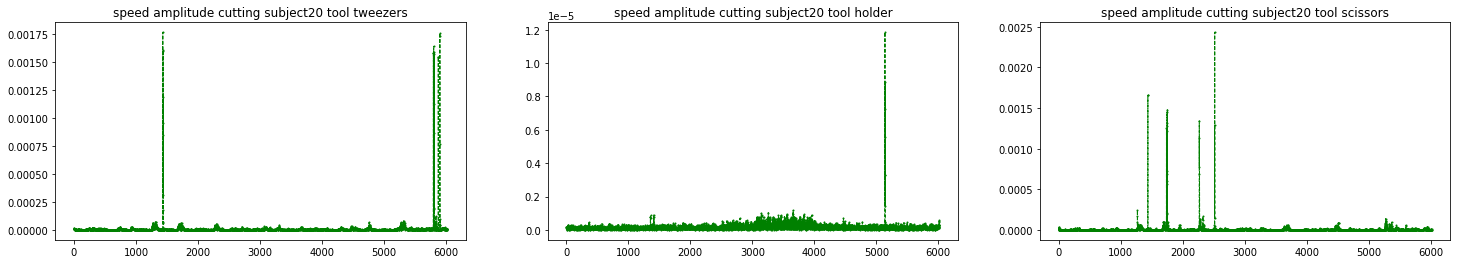

<Figure size 432x288 with 0 Axes>

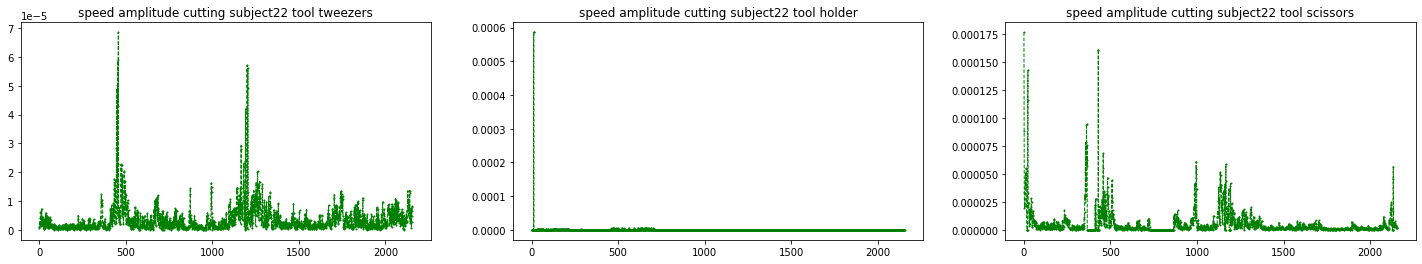

In [65]:
# graph of all segments pu next to each other = for shorter segments we could visaully inspect this
for a in action:
    for d in subject_nb:  
        id_s = len(run_dir[a][d])
        plt.figure()
        fig, axs = plt.subplots(1, 3, figsize=(25, 4))
        for i, tool in enumerate(tools):
            y = []
            for s in range(id_s): #s prend la valeur des segments            
                #tmp = (x_speed[a][d][s][tool])
                tmp = (amp_speed[a][d][s][tool])
                y = np.concatenate((y,tmp), axis = None)
            
            axs[i].plot(y, color='green', marker='o', linestyle='dashed', linewidth=1, markersize=1) #3 tools for 5 subjects fro 2 actions = 30 graphs
            axs[i].set_title("speed amplitude " + a + " subject" + d+ " tool " + tool)
            
            
            #bizarre d'avoir des valeurs pour scissors pour l-action suturing (surtout pour 14) 